<a href="https://colab.research.google.com/github/SopyeongKim/MAT3123/blob/main/Monte%20Carlo%20Simulation%20with%20LSTM%20Trend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


📈 The Langevin Trader: 몬테카를로 주가 예측 시뮬레이터
[입력 팁]
- 한국 주식: 종목코드 뒤에 .KS (코스피) 또는 .KQ (코스닥) 붙이기
  (예: 삼성전자 005930.KS, 카카오 035720.KS, 에코프로비엠 247540.KQ)
- 미국 주식: 티커 그대로 입력 (예: 애플 AAPL, 테슬라 TSLA, 엔비디아 NVDA)
>> 분석할 기업의 티커(Ticker)를 입력하세요 (엔터 치면 삼성전자): 035720.KS

📥 [035720.KS] 데이터를 다운로드 중입니다...


/tmp/ipython-input-3047765584.py:50: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START_DATE, progress=False)


✅ 데이터 로드 완료: 총 1464일 치 데이터

🚀 모델 학습 시작 (LSTM Training)...
Epoch [10/50], Loss: 0.054913
Epoch [20/50], Loss: 0.031676
Epoch [30/50], Loss: 0.004146
Epoch [40/50], Loss: 0.001476
Epoch [50/50], Loss: 0.000688

🎲 몬테카를로 시뮬레이션 수행 중 (MCMC)...


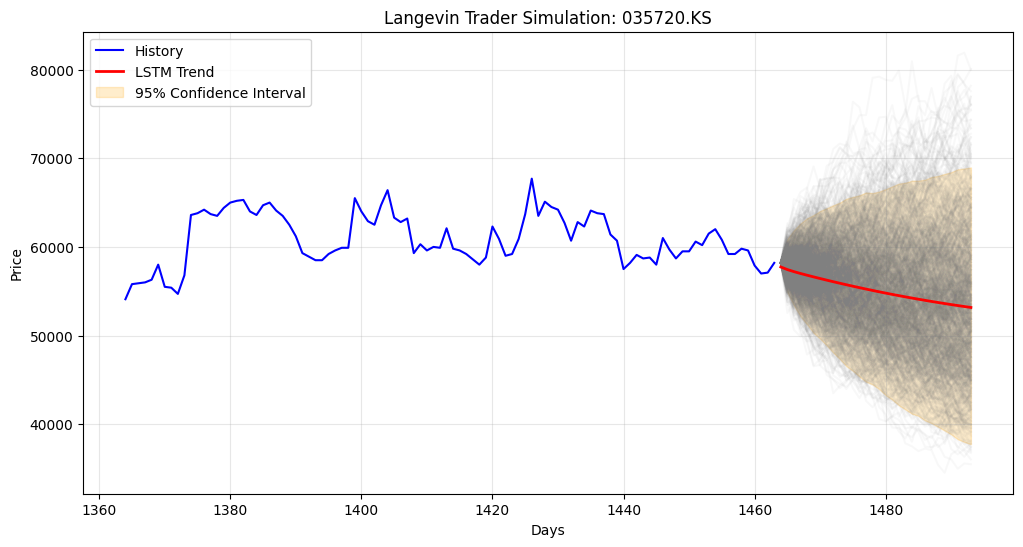


✨ 완료! [035720.KS]의 예측 그래프가 생성되었습니다.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import sys

# ---------------------------------------------------------
# 1. 설정 및 사용자 입력 (Configuration & Input)
# ---------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_ticker_input():
    print("\n" + "="*60)
    print("📈 The Langevin Trader: 몬테카를로 주가 예측 시뮬레이터")
    print("="*60)
    print("[입력 팁]")
    print("- 한국 주식: 종목코드 뒤에 .KS (코스피) 또는 .KQ (코스닥) 붙이기")
    print("  (예: 삼성전자 005930.KS, 카카오 035720.KS, 에코프로비엠 247540.KQ)")
    print("- 미국 주식: 티커 그대로 입력 (예: 애플 AAPL, 테슬라 TSLA, 엔비디아 NVDA)")
    print("="*60)

    ticker = input(">> 분석할 기업의 티커(Ticker)를 입력하세요 (엔터 치면 삼성전자): ").strip()

    # 아무것도 입력 안 하고 엔터 치면 기본값(삼성전자) 설정
    if not ticker:
        ticker = '005930.KS'
        print("기본값(삼성전자, 005930.KS)으로 진행합니다.")
    return ticker

# 사용자로부터 티커 입력 받기
TICKER = get_ticker_input()

# 하이퍼파라미터 설정
START_DATE = '2020-01-01' # 데이터 수집 시작일
# END_DATE는 오늘 날짜로 자동 설정하거나 고정할 수 있음 (여기선 yfinance가 알아서 최신까지 가져오도록 처리)
SEQ_LENGTH = 60     # 지난 60일의 데이터를 보고
PREDICT_DAYS = 30   # 향후 30일을 예측
SIMULATIONS = 1000  # 몬테카를로 시뮬레이션 횟수 (MCMC)

# ---------------------------------------------------------
# 2. 데이터 전처리 (Data Preparation)
# ---------------------------------------------------------
def load_data(ticker):
    print(f"\n📥 [{ticker}] 데이터를 다운로드 중입니다...")
    # 오늘 날짜까지의 데이터를 가져옵니다
    df = yf.download(ticker, start=START_DATE, progress=False)

    if df.empty:
        print(f"❌ 에러: '{ticker}'에 대한 데이터를 찾을 수 없습니다.")
        print("티커가 정확한지 확인해주세요. (예: 한국주식은 .KS나 .KQ 확인)")
        sys.exit() # 프로그램 종료

    # 'Close' 컬럼만 사용
    data = df['Close'].values.reshape(-1, 1)
    print(f"✅ 데이터 로드 완료: 총 {len(data)}일 치 데이터")
    return data

# 데이터 로드 및 정규화
try:
    raw_data = load_data(TICKER)
except Exception as e:
    print(f"데이터 로드 중 오류 발생: {e}")
    sys.exit()

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(raw_data)

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X, y = create_sequences(scaled_data, SEQ_LENGTH)

# 학습 데이터가 너무 적을 경우 예외 처리
if len(X) == 0:
    print("❌ 에러: 데이터가 너무 적어 학습할 수 없습니다. SEQ_LENGTH를 줄이거나 더 오래된 기업을 선택하세요.")
    sys.exit()

# Tensor 변환
X_tensor = torch.from_numpy(X).float().to(device)
y_tensor = torch.from_numpy(y).float().to(device)

# ---------------------------------------------------------
# 3. LSTM 모델 정의 (Model Architecture)
# ---------------------------------------------------------
class StockLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(StockLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = StockLSTM().to(device)

# ---------------------------------------------------------
# 4. 학습 루프 (Training Loop - Gradient Descent)
# ---------------------------------------------------------
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

print("\n🚀 모델 학습 시작 (LSTM Training)...")
epochs = 50 # 시연을 위해 50으로 설정 (필요시 100으로 증가)
for epoch in range(epochs):
    model.train()
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')

# ---------------------------------------------------------
# 5. 몬테카를로 시뮬레이션 (MCMC & Langevin Dynamics Logic)
# ---------------------------------------------------------
print("\n🎲 몬테카를로 시뮬레이션 수행 중 (MCMC)...")

# 5.1 추세(Drift) 예측
model.eval()
last_sequence = X_tensor[-1].unsqueeze(0)
predicted_trend = []

curr_seq = last_sequence
with torch.no_grad():
    for _ in range(PREDICT_DAYS):
        pred = model(curr_seq)
        predicted_trend.append(pred.item())
        new_seq = torch.cat((curr_seq[:, 1:, :], pred.unsqueeze(1)), dim=1)
        curr_seq = new_seq

predicted_trend = scaler.inverse_transform(np.array(predicted_trend).reshape(-1, 1))
current_price = scaler.inverse_transform(y_tensor[-1].cpu().detach().numpy().reshape(-1, 1))[0][0]

# 5.2 변동성(Volatility) 계산
recent_prices = scaler.inverse_transform(X[-1].reshape(-1, 1))
# 로그 수익률 계산 시 0이나 음수 방지를 위해 안전장치 추가
safe_prices = np.where(recent_prices <= 0, 1e-8, recent_prices)
returns = np.diff(np.log(safe_prices), axis=0)
volatility = np.std(returns)

# 5.3 랑주뱅 역학 시뮬레이션
simulation_results = np.zeros((PREDICT_DAYS, SIMULATIONS))
simulation_results[0, :] = current_price

for t in range(1, PREDICT_DAYS):
    # Drift: LSTM 예측 기울기
    drift = (predicted_trend[t] - predicted_trend[t-1]) / predicted_trend[t-1]

    # Diffusion: Langevin Noise
    shock = volatility * np.random.normal(0, 1, SIMULATIONS)

    simulation_results[t, :] = simulation_results[t-1, :] * (1 + drift + shock)

# ---------------------------------------------------------
# 6. 결과 시각화 (Visualization)
# ---------------------------------------------------------
plt.figure(figsize=(12, 6))

# 과거 데이터 (최근 100일)
plt.plot(range(len(raw_data)-100, len(raw_data)), raw_data[-100:], label='History', color='blue')

# 미래 예측 (시뮬레이션)
future_idx = range(len(raw_data), len(raw_data) + PREDICT_DAYS)
plt.plot(future_idx, simulation_results, color='gray', alpha=0.05)

# LSTM 추세선
plt.plot(future_idx, predicted_trend, label='LSTM Trend', color='red', linewidth=2)

# 신뢰 구간
mean_sim = np.mean(simulation_results, axis=1)
std_sim = np.std(simulation_results, axis=1)
plt.fill_between(future_idx, mean_sim - 1.96*std_sim, mean_sim + 1.96*std_sim, color='orange', alpha=0.2, label='95% Confidence Interval')

plt.title(f'Langevin Trader Simulation: {TICKER}')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n✨ 완료! [{TICKER}]의 예측 그래프가 생성되었습니다.")